In [30]:
%matplotlib inline
import numpy as np
from time import sleep
from IPython.display import clear_output
from matplotlib import pyplot as plt
from typing import List

In [60]:
class ForwardPrice:
    """
    An observed price for some delivery time T
    """
    def __init__(self, T, P):
        self.T = T
        self.P = P
        
class ForwardPriceCurve:
    """
    A collection of prices for various delivery times, observed at some time
    """
    def __init__(self, observation_time: Number, forward_prices: List[ForwardPrice]):
        self.observation_time = observation_time
        self.forward_prices = forward_prices
        
    
    def remove_deliveries_expiring_before(self, boundary):
        return ForwardPriceCurve(
            self.observation_time,
            [fp for fp in self.forward_prices if fp.T >= boundary]
        )
    
    @property
    def delivery_times(self):
        return [fp.T for fp in self.forward_prices]
    
    @property
    def prices(self):
        return [fp.P for fp in self.forward_prices]
    
    @staticmethod
    def build_with_seasonality(delivery_times, average_price, seasonality):
        return ForwardPriceCurve(
            observation_time=0,
            forward_prices=[
                ForwardPrice(
                    T,
                    average_price + np.sin(T * 2 * np.pi) * seasonality
                )
                for T in delivery_times
            ]
        )


In [54]:
def draw_forward_price_curve(fpc):
    fig, ax = plt.subplots()
    line, = ax.plot([])
    ax.set_xlim(0, fpc.delivery_times[-1])
    ax.set_ylim(50, 150)
    line.set_data(fpc.delivery_times, fpc.prices)
    plt.show()

In [43]:
from abc import ABC, abstractmethod
from numbers import Number

class PriceProcess(ABC):
    def __init__(self):
        self.rng = np.random.default_rng()
        
    @abstractmethod
    def evolve(fpc: ForwardPriceCurve, next_observation_time: Number):
        """ randomly perturb the forward curve"""
  

In [65]:
class LognormalProcessWithExponentialDecay(PriceProcess):
    def __init__(self, alphas: List[Number], vols: List[Number]):
        super().__init__()
        self.alphas = alphas
        self.vols = vols

    def evolve(self, fpc, next_observation_time):
        dt = next_observation_time - fpc.observation_time
        dz = self.rng.normal(scale=dt)
        live_fpc = fpc.remove_deliveries_expiring_before(next_observation_time)

        def risk_adj(s):
            return 0.5 * s * s * dt
        
        evolved_prices = []
        for fp in live_fpc.forward_prices:
            evolved_price = fp.P
            for alpha, vol in zip(self.alphas, self.vols):
                scaled_vol = np.exp(-alpha * (fp.T - t)) * vol
                evolved_price *= np.exp(scaled_vol * dz - risk_adj(scaled_vol))
            evolved_prices.append(ForwardPrice(fp.T, evolved_price))
            
        return ForwardPriceCurve(
            next_observation_time,
            evolved_prices
        )
                                
        

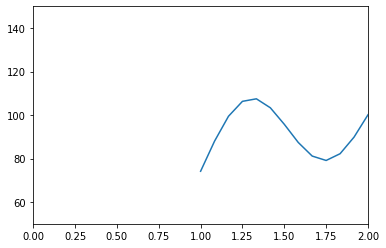

In [68]:
num_years = 2
delivery_times = [i / 12 for i in range(12 * num_years + 1)]
fpc = ForwardPriceCurve.build_with_seasonality(delivery_times, average_price=100, seasonality=20)
process = LognormalProcessWithExponentialDecay(
    alphas=[1.5],
    vols=[1.6]
)
observation_times = [i / 52.0 for i in range(53)]

for t in observation_times:
    draw_forward_price_curve(fpc)
    clear_output(wait=True)
    sleep(0.1)
    fpc = process.evolve(fpc, t)

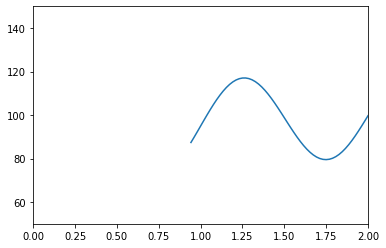

In [33]:


rng = np.random.default_rng()
num_years = 2


dt = 1.0 / 52
delivery_times = [ i / 52 for i in range(52 * num_years + 1) ]

forward_prices = construct_forward_prices(delivery_times, average_price = 100, seasonality=20)


alpha = 1.5
sigma = 0.6

kappa = 0.5
spot_daily_std_dev = 2.0
spot_weekly_std_dev = spot_daily_std_dev * np.sqrt(7)

def risk_adj(s):
    return 0.5 * s * s * dt

def move_to_week(i_week):

    dz = rng.normal(scale=dt)
    live_week_indices = week_indices[i_week:]
    t = delivery_times[i_week]
    #spot_price = forward_prices[i_week]
    #ma_price = forward_prices[i_week + 4]

    
    for i in live_week_indices:
        T = delivery_times[i]
        scaled_sigma = sigma * np.exp(- alpha * (T - t))
        forward_prices[i] *= np.exp(scaled_sigma * dz - risk_adj(scaled_sigma))
    #d_spot = rng.normal(scale=spot_weekly_std_dev)
    #forward_prices[i_week] += kappa * (ma_price - spot_price) + d_spot
    draw_forward_prices(delivery_times[i_week:], forward_prices[i_week:])
    clear_output(wait=True)
    sleep(0.1)
    
num_time_steps = 50
    
for i_week in range(num_time_steps):
    move_to_week(i_week)
